[*********************100%%**********************]  1 of 1 completed
                           Open        High         Low       Close  \
Datetime                                                              
2024-01-02 09:30:00  250.080002  250.899994  244.410004  248.794006   
2024-01-02 10:00:00  248.779999  251.250000  248.050003  249.610001   
2024-01-02 10:30:00  249.600006  249.638199  246.820007  248.919998   
2024-01-02 11:00:00  248.899994  250.259995  248.339996  250.000000   
2024-01-02 11:30:00  249.994095  251.000000  249.900101  250.475403   
...                         ...         ...         ...         ...   
2024-01-26 13:30:00  183.490097  183.630005  182.291000  182.644394   
2024-01-26 14:00:00  182.654999  182.660004  182.100006  182.280106   
2024-01-26 14:30:00  182.300003  183.380005  182.119995  183.270004   
2024-01-26 15:00:00  183.270004  183.320007  182.380005  182.630005   
2024-01-26 15:30:00  182.629898  183.470001  182.610001  183.229904   

       

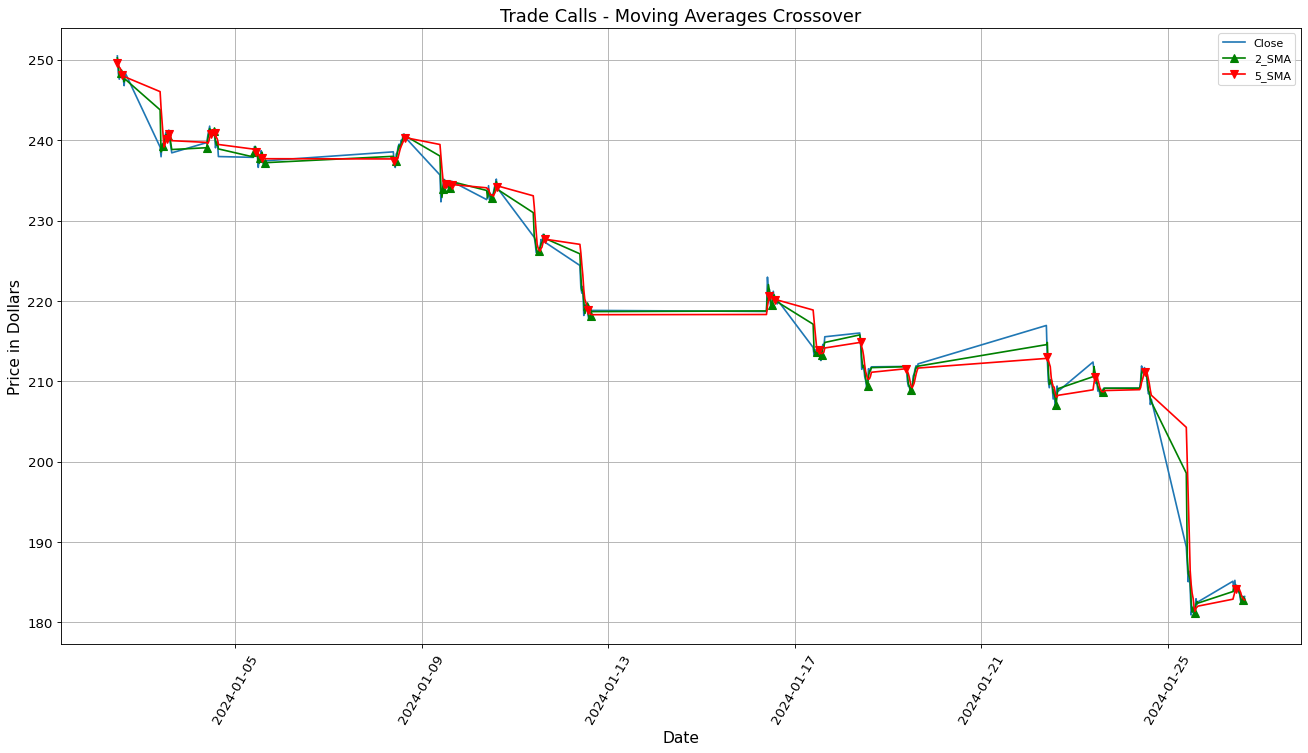

In [1]:
import pandas as pd
import requests 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from pyfile.scrapestockdata import data_tsla, Trade_Buy, Trade_Sell
analyzer = SentimentIntensityAnalyzer()

In [2]:
news_df = pd.read_csv('articles.csv')

final_news = news_df.loc[:,['publishedAt','description']]
final_news['date'] = pd.to_datetime(final_news['publishedAt'])
final_news.sort_values(by='publishedAt',inplace=True)
final_news

,publishedAt,description,date
52,2024-01-04T02:07:54Z,The Nasdaq extended a losing streak. Tesla fel...,2024-01-04 02:07:54+00:00
93,2024-01-04T11:00:38Z,"Given its better prospects, we believe Alaska ...",2024-01-04 11:00:38+00:00
38,2024-01-04T11:47:00Z,This bank is raising dry powder as they see a ...,2024-01-04 11:47:00+00:00
32,2024-01-04T12:00:15Z,"Tesla reported 485,000 deliveries for Q4 2023,...",2024-01-04 12:00:15+00:00
22,2024-01-04T13:18:11Z,The EV market leader could yet again disprove ...,2024-01-04 13:18:11+00:00
...,...,...,...
98,2024-01-29T12:18:58Z,"If you’re a small investor in Tesla like I am,...",2024-01-29 12:18:58+00:00
69,2024-01-29T12:30:00Z,"The company reported revenue of $13.6 billion,...",2024-01-29 12:30:00+00:00
82,2024-01-29T13:30:00Z,"Given its better prospects, we believe Medtron...",2024-01-29 13:30:00+00:00
33,2024-01-29T19:26:06Z,The Magnificent Seven are already starting to ...,2024-01-29 19:26:06+00:00


In [3]:
# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay

# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None

In [4]:
 # Apply the above function to get the trading time for each news headline
final_news["trading_time"] = final_news["publishedAt"].apply(get_trade_open)

final_news = final_news[pd.notnull(final_news['trading_time'])]
final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)
final_news

C:\Users\DELL\AppData\Local\Temp\ipykernel_23136\3040318134.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)


,publishedAt,description,date,trading_time,Date
52,2024-01-04T02:07:54Z,The Nasdaq extended a losing streak. Tesla fel...,2024-01-04 02:07:54+00:00,2024-01-04 13:30:00+00:00,2024-01-04
93,2024-01-04T11:00:38Z,"Given its better prospects, we believe Alaska ...",2024-01-04 11:00:38+00:00,2024-01-04 13:30:00+00:00,2024-01-04
38,2024-01-04T11:47:00Z,This bank is raising dry powder as they see a ...,2024-01-04 11:47:00+00:00,2024-01-04 13:30:00+00:00,2024-01-04
32,2024-01-04T12:00:15Z,"Tesla reported 485,000 deliveries for Q4 2023,...",2024-01-04 12:00:15+00:00,2024-01-04 13:30:00+00:00,2024-01-04
22,2024-01-04T13:18:11Z,The EV market leader could yet again disprove ...,2024-01-04 13:18:11+00:00,2024-01-04 13:30:00+00:00,2024-01-04
...,...,...,...,...,...
81,2024-01-29T07:16:23Z,Tesla (TSLA) CEO Elon Musk and the company’s t...,2024-01-29 07:16:23+00:00,2024-01-29 13:30:00+00:00,2024-01-29
41,2024-01-29T10:24:05Z,"Famed investor Cathie Wood, who heads up Ark I...",2024-01-29 10:24:05+00:00,2024-01-29 13:30:00+00:00,2024-01-29
98,2024-01-29T12:18:58Z,"If you’re a small investor in Tesla like I am,...",2024-01-29 12:18:58+00:00,2024-01-29 13:30:00+00:00,2024-01-29
69,2024-01-29T12:30:00Z,"The company reported revenue of $13.6 billion,...",2024-01-29 12:30:00+00:00,2024-01-29 13:30:00+00:00,2024-01-29


In [5]:
# getting compound for each news headline
cs = []
for row in range(len(final_news)):
    cs.append(analyzer.polarity_scores(final_news['description'].iloc[row])['compound'])

final_news['compound_vader_score'] = cs
final_news

C:\Users\DELL\AppData\Local\Temp\ipykernel_23136\438150302.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_news['compound_vader_score'] = cs


,publishedAt,description,date,trading_time,Date,compound_vader_score
52,2024-01-04T02:07:54Z,The Nasdaq extended a losing streak. Tesla fel...,2024-01-04 02:07:54+00:00,2024-01-04 13:30:00+00:00,2024-01-04,-0.2023
93,2024-01-04T11:00:38Z,"Given its better prospects, we believe Alaska ...",2024-01-04 11:00:38+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.7906
38,2024-01-04T11:47:00Z,This bank is raising dry powder as they see a ...,2024-01-04 11:47:00+00:00,2024-01-04 13:30:00+00:00,2024-01-04,-0.2023
32,2024-01-04T12:00:15Z,"Tesla reported 485,000 deliveries for Q4 2023,...",2024-01-04 12:00:15+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.3182
22,2024-01-04T13:18:11Z,The EV market leader could yet again disprove ...,2024-01-04 13:18:11+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.2263
...,...,...,...,...,...,...
81,2024-01-29T07:16:23Z,Tesla (TSLA) CEO Elon Musk and the company’s t...,2024-01-29 07:16:23+00:00,2024-01-29 13:30:00+00:00,2024-01-29,0.5267
41,2024-01-29T10:24:05Z,"Famed investor Cathie Wood, who heads up Ark I...",2024-01-29 10:24:05+00:00,2024-01-29 13:30:00+00:00,2024-01-29,0.7629
98,2024-01-29T12:18:58Z,"If you’re a small investor in Tesla like I am,...",2024-01-29 12:18:58+00:00,2024-01-29 13:30:00+00:00,2024-01-29,0.7351
69,2024-01-29T12:30:00Z,"The company reported revenue of $13.6 billion,...",2024-01-29 12:30:00+00:00,2024-01-29 13:30:00+00:00,2024-01-29,0.3818


In [6]:
final_news = final_news[(final_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)
final_news

,publishedAt,description,date,trading_time,Date,compound_vader_score
0,2024-01-04T02:07:54Z,The Nasdaq extended a losing streak. Tesla fel...,2024-01-04 02:07:54+00:00,2024-01-04 13:30:00+00:00,2024-01-04,-0.2023
1,2024-01-04T11:00:38Z,"Given its better prospects, we believe Alaska ...",2024-01-04 11:00:38+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.7906
2,2024-01-04T11:47:00Z,This bank is raising dry powder as they see a ...,2024-01-04 11:47:00+00:00,2024-01-04 13:30:00+00:00,2024-01-04,-0.2023
3,2024-01-04T12:00:15Z,"Tesla reported 485,000 deliveries for Q4 2023,...",2024-01-04 12:00:15+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.3182
4,2024-01-04T13:18:11Z,The EV market leader could yet again disprove ...,2024-01-04 13:18:11+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.2263
5,2024-01-05T11:00:37Z,"Amid the current financial backdrop, ADBE stoc...",2024-01-05 11:00:37+00:00,2024-01-05 13:30:00+00:00,2024-01-05,0.5719
6,2024-01-05T11:34:00Z,Cybersecurity stocks will benefit from structu...,2024-01-05 11:34:00+00:00,2024-01-05 13:30:00+00:00,2024-01-05,0.4588
7,2024-01-05T13:00:49Z,"Given its better prospects, we believe Target ...",2024-01-05 13:00:49+00:00,2024-01-05 13:30:00+00:00,2024-01-05,0.7906
8,2024-01-08T12:00:09Z,"Barclays’ stock (NYSE: BCS) has gained 1% YTD,...",2024-01-08 12:00:09+00:00,2024-01-08 13:30:00+00:00,2024-01-08,0.1280
9,2024-01-08T13:00:00Z,"There is more to the comparison, and in the se...",2024-01-08 13:00:00+00:00,2024-01-08 13:30:00+00:00,2024-01-08,0.4404


In [7]:
# Retaining extreme (max and min) compound scores for same Day news headlines
unique_dates = final_news['Date'].unique()
grouped_dates = final_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)

In [8]:
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

#summing and calculating Vader score
final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores
extreme_scores_df

,Date,max_scores,min_scores,final_scores
0,2024-01-04,0.7906,-0.2023,0.5883
1,2024-01-05,0.7906,0.0000,0.7906
2,2024-01-08,0.4404,0.0000,0.4404
3,2024-01-09,0.0000,-0.2500,-0.2500
4,2024-01-10,0.4404,0.0000,0.4404
5,2024-01-11,0.4588,0.0000,0.4588
6,2024-01-12,0.3818,-0.2732,0.1086
7,2024-01-15,0.0000,-0.5719,-0.5719
8,2024-01-16,0.2960,0.0000,0.2960
9,2024-01-17,0.0000,-0.7269,-0.7269


In [9]:
#Using final compound VADER scores with threshold to generate trade calls
# VADER trade calls - with threshold
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.2:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.2:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

vader_buy = []
for i in range(len(data_tsla)):
    if data_tsla.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(data_tsla)):
    if data_tsla.index[i].date() in vader_Sell:
        vader_sell.append(i)

print(vader_buy)
print(vader_sell)

Trade Call for 2024-01-04 is Buy.
Trade Call for 2024-01-05 is Buy.
Trade Call for 2024-01-08 is Buy.
Trade Call for 2024-01-09 is Sell.
Trade Call for 2024-01-10 is Buy.
Trade Call for 2024-01-11 is Buy.
Trade Call for 2024-01-15 is Sell.
Trade Call for 2024-01-16 is Buy.
Trade Call for 2024-01-17 is Sell.
Trade Call for 2024-01-18 is Buy.
Trade Call for 2024-01-19 is Buy.
Trade Call for 2024-01-22 is Buy.
Trade Call for 2024-01-23 is Buy.
Trade Call for 2024-01-24 is Sell.
Trade Call for 2024-01-25 is Sell.
Trade Call for 2024-01-26 is Sell.
Trade Call for 2024-01-29 is Buy.
Trade Call for 2024-01-30 is Buy.
[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 1

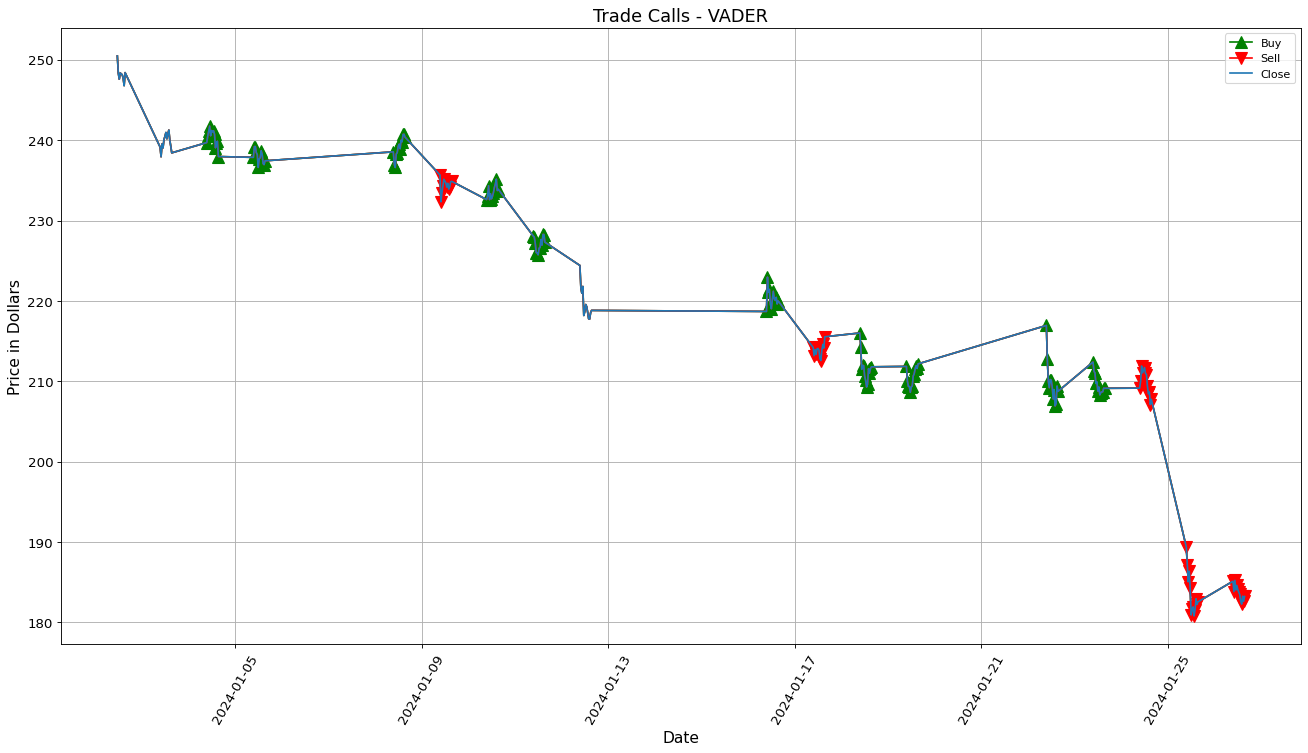

In [10]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_tsla.index, data_tsla['Close'],'-^', markevery=vader_buy, ms=10, color='green')
plt.plot(data_tsla.index, data_tsla['Close'],'-v', markevery=vader_sell, ms=10, color='red')
plt.plot(data_tsla.index, data_tsla['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

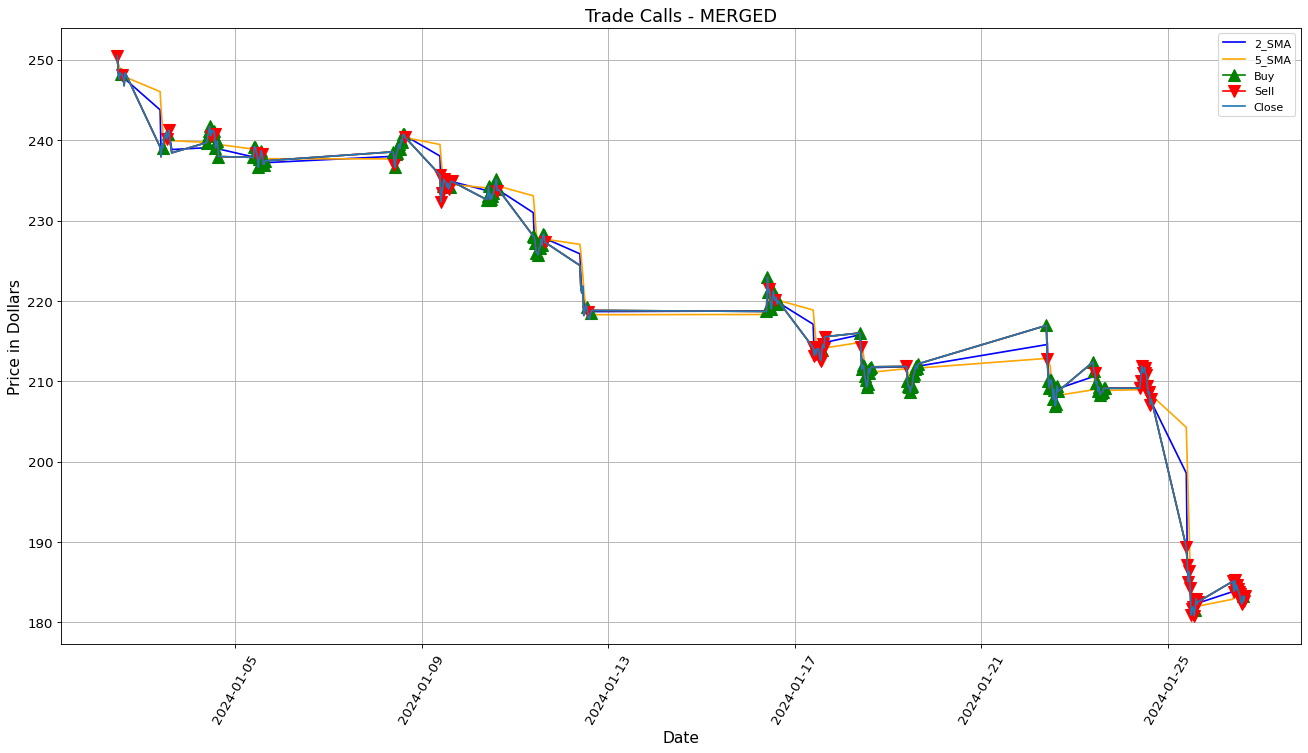

In [11]:
#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_tsla.index, data_tsla['2_SMA'], color='blue')
plt.plot(data_tsla.index, data_tsla['5_SMA'], color='orange')
plt.plot(data_tsla.index, data_tsla['Close'],'-^', markevery=final_buy, ms=10, color='green')
plt.plot(data_tsla.index, data_tsla['Close'],'-v', markevery=final_sell, ms=10, color='red')
plt.plot(data_tsla.index, data_tsla['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show() 

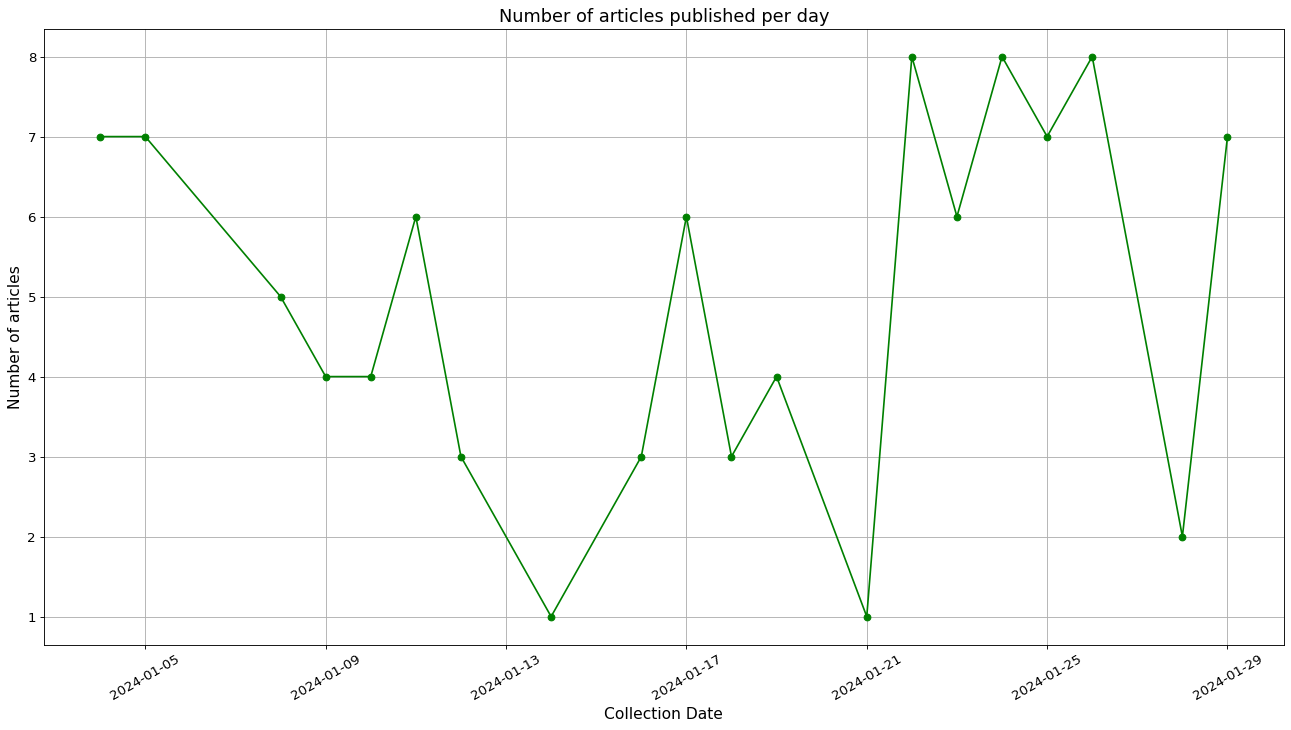

In [12]:
import matplotlib.pyplot as plt

# Đảm bảo rằng cột 'date' là kiểu dữ liệu datetime
news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'])
news_df['date'] = news_df['publishedAt'].dt.date

# Tính toán số lượng content mỗi ngày
content_count = news_df.groupby('date').size()

# Vẽ biểu đồ
plt.figure(figsize=(20,10), dpi=80)
content_count.plot(kind='line', marker='o', color='green')
plt.title('Number of articles published per day', fontsize = 16)
plt.xlabel('Collection Date', fontsize=14)
plt.ylabel('Number of articles',fontsize = 14)
plt.xticks(rotation=30,fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()